# Import

In [1]:
import numpy as np
import netCDF4 as nc
import os
import rasterio
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
from numba import cuda

### Helper functions

In [26]:
def latitude_converted(lat: float):
    """
    Convert latitude value to value between 0 and 720 (0.25 degree representation of latitude)
    :param lat: The actual latitude we want to covert to the 720 format
    """
    return (90 - lat) * 4

def longitude_converted(lon: float):
    """
    Convert longitude value to value between 0 and 1440 (0.25 degree representation of longitude)
    :param lon: The actual longitude we want to convert to the 1440 format 
    """
    return (-180 - lon) * -4

Function that loads a netCDF File

In [17]:
def load_netcdf_file(path: str):
    """
    Open a netCDF File, NOTE: After being done with the file don't forgoet to use nc_file.close() to close the file.
    :param path: The absolute path to the netCDF file.
    """
    nc_file = nc.Dataset(file, 'r')
    return nc_file

file = "E:\\Project\\Urban computing\\data\Burned area patch\\2003\\20030801-ESACCI-L4_FIRE-BA-MODIS-fv5.1.nc"
data = load_netcdf_file(file)

Create the South korea matrix from the "burned_area" variable in the netCDF file

In [18]:
def create_ba_matrix_one_month(nc_file):
    """
    Create the Burned Area matrix for South Korea NOTE: Do not forget to call nc_file.close() after finishing with the file.
    :param nc_file: The netCDF Dataset of the monthly data.
    """
    ba_matrix = np.array(nc_file.variables['burned_area'])
    
    # Convert lat and long to the 720 and 1440 degree format respectively
    max_lat_idx = latitude_converted(south_korea_lat_max)
    min_lat_idx = latitude_converted(south_korea_lat_min)
    max_lon_idx = longitude_converted(south_korea_lon_max)
    min_lon_idx = longitude_converted(south_korea_lon_min)

    # Create the south korea BA matrix
    south_korea_matrix = ba_matrix[:, max_lat_idx:min_lat_idx, min_lon_idx:max_lon_idx]
    return south_korea_matrix


# south_korea = create_ba_matrix_one_month(data)
# south_korea.shape

### Combine data
Create a single dataset which contains the korea BA matrix over all the months of the years range 2001-2020

In [15]:
def combine_data(root_folder):
    """
    Combine data from multiple NetCDF files.
    :param root_folder: The root folder containing yearly subfolders.
    :return: Combined dataset for South Korea.
    """
    combined_data = None

    for year_folder in os.listdir(root_folder):
        year_path = os.path.join(root_folder, year_folder)

        for month_file in os.listdir(year_path):
            file_path = os.path.join(year_path, month_file)

            # Open the NetCDF file
            with nc.Dataset(file_path, 'r') as nc_file:
                south_korea_data = create_ba_matrix_one_month(nc_file)

                if combined_data is None:
                    combined_data = south_korea_data
                else:
                    # Combine the data along the time dimension (assuming the first dimension is time)
                    combined_data = np.concatenate((combined_data, south_korea_data), axis=0)

    return combined_data

# Specify the root folder where your data is stored
data_root_folder = 'E:\\Project\\Urban computing\\data'

# Call the combine_data function
combined_data = combine_data(data_root_folder)

# Now, combined_data contains the aggregated burned area data for South Korea from all files.
np.save(file="combined_data.npy" , arr=combined_data)

In [19]:
loaded_data = np.load('combined_data.npy')
loaded_data.shape
loaded_data[1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

# Load GeoTIFF

In [2]:
south_korea_lat_min = 32
south_korea_lat_max = 39
south_korea_lon_min = 125
south_korea_lon_max = 130

In [3]:
def pixel_long_to_idx(long: float):
    if long < 52.999301 or  long > 179.99999999952965:
        return ValueError
    return (long - 52.999301) / 0.0022457331

def pixel_lat_to_idx(latitude: float):
    if latitude < 0 or  latitude > 83.00004990518016:
        return ValueError
    return (latitude - 1.4210854715202004e-14) / 0.0022457331

# Function to clip the TIFF file
def clip_tiff(file_path, lon_min, lon_max, lat_min, lat_max):
    data = rioxarray.open_rasterio(file_path)
    clipped_data = data.rio.clip_box(minx=lon_min, miny=lat_min, maxx=lon_max, maxy=lat_max)
    return clipped_data


In [8]:
import pickle

# Base directory containing the folders
base_dir = "E:\\Project\\Urban computing\\data\\Pixel Data"

# Dataset to store the clipped data
dataset = []
counter = 0
# Loop through each year directory
for year in os.listdir(base_dir):
    year_dir = os.path.join(base_dir, year)

    # Loop through each subdirectory in the year directory
    for root, dirs, files in os.walk(year_dir):
        for file in files:
            if file.endswith("-CL.tif"):
                file_path = os.path.join(root, file)

                # Extract the 'month' from the directory name if necessary
                month = os.path.basename(root)  # or any other logic to determine the month from the folder name

                # Clip the data and add to the dataset
                clipped_data = clip_tiff(file_path, south_korea_lon_min, south_korea_lon_max, south_korea_lat_min, south_korea_lat_max)
                clipped_data = clipped_data.squeeze() # Remove the band data
                clipped_data = clipped_data.assign_coords({"month": counter})
                clipper_data = clipped_data.expand_dims(dim = "month")
                dataset.append(clipped_data)
                counter += 1


In [ ]:
# Concatenate all DataArrays in the dataset list along the 'month' dimension
combined_data = xr.concat(dataset, dim="month")

combined_data.rio.to_raster("kr_data.tif")


In [5]:
# data_arrays = [item[2] for item in dataset]  # Extract the DataArray from each tuple
# print(dataset[150][2])

# # Stack the arrays along a new axis (0th axis for time)
# combined_numpy_array = np.stack(data_arrays, axis=0)

# # Print the shape of the resulting NumPy array
# reduced_dim = np.squeeze(combined_numpy_array)
# print(reduced_dim.shape)
# np.save(arr=reduced_dim, file="south_korea_CL.npy")

loaded_data = rioxarray.open_rasterio("kr_data.tif")


# Load data in for plotting

In [26]:
loaded_data[0]

<xarray.DataArray (y: 3118, x: 2227)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
    band         int32 1
  * x            (x) float64 125.0 125.0 125.0 125.0 ... 130.0 130.0 130.0 130.0
  * y            (y) float64 39.0 39.0 39.0 38.99 ... 32.01 32.01 32.0 32.0
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    scale_factor:            1.0
    add_offset:              0.0

# STAR model implementation

# Spatio-temporal forecasting using ConvLSTM Architecture

In [44]:
new_array = loaded_data.to_numpy()
new_array = new_array.astype(np.dtypes.Float32DType)
np.save('training_array_f32.npy', new_array)

In [17]:
# Load saved data
training_data = np.load("training_array_f32.npy")

In [32]:
# Dataset normalization between 0 and 1 
def custom_normalize(data):
    # Normalize values between 1 and 100
    normalized_data = np.where((data > 0) & (data <= 100), data / 100, data)

    return normalized_data

# Assuming 'dataset' is your numpy array with shape (240, 3118, 2227)
normalized_dataset = custom_normalize(training_data)
np.save("training_array_f32_normalized.npy", normalized_dataset)

In [2]:
# Load appropriate normalized dataset
normalized_dataset = np.load("training_array_f16_normalized.npy")

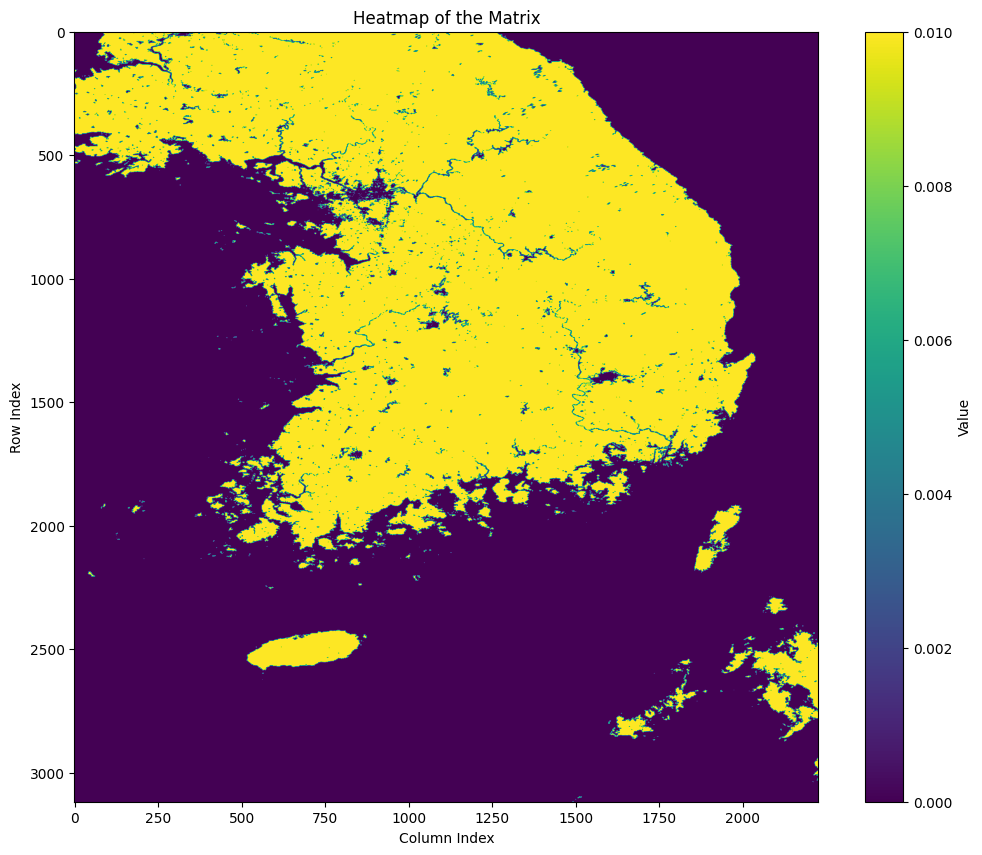

In [36]:
# quick exploration of the data

plt.figure(figsize=(12, 10))
plt.imshow(normalized_dataset[7], cmap='viridis', aspect='auto')  # 'aspect=auto' adjusts the aspect ratio to fit the dimensions
plt.colorbar(label='Value')
plt.title("Heatmap of the Matrix")
plt.xlabel("Column Index")
plt.ylabel("Row Index")
plt.show()

In [3]:
# Create windowed training dataset
def create_windowed_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 2  # Using x amount of months of data to predict the next month
X, y = create_windowed_dataset(normalized_dataset, window_size)
print(f'x shape/dtype: {X.shape} {X.dtype}, y shape/dtype: {y.shape} {y.dtype}')

x shape/dtype: (238, 2, 3118, 2227) float16, y shape/dtype: (238, 3118, 2227) float16


In [20]:
# save X and y
np.save("X_f16.npy", X)
np.save("y_f16.npy", y)

In [2]:
# Load X and y
X = np.load("X_f16.npy")
y = np.load("y_f16.npy")

In [4]:
# Define the split indices
train_end = 188
test_end = train_end + 22
val_end = test_end + 24
pred_start = val_end
pred_end = pred_start + 2  # We want 2 samples for prediction

# Split the dataset
X_train, y_train = X[:train_end], y[:train_end]
X_test, y_test = X[train_end:test_end], y[train_end:test_end]
X_val, y_val = X[test_end:val_end], y[test_end:val_end]
X_pred, y_pred = X[pred_start:pred_end], y[pred_start:pred_end]

# Print the shapes of the splits to verify
print(f"Train Shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test Shape: X={X_test.shape}, y={y_test.shape}")
print(f"Validation Shape: X={X_val.shape}, y={y_val.shape}")
print(f"Prediction Shape: X={X_pred.shape}, y={y_pred.shape}")

Train Shape: X=(188, 2, 3118, 2227), y=(188, 3118, 2227)
Test Shape: X=(22, 2, 3118, 2227), y=(22, 3118, 2227)
Validation Shape: X=(24, 2, 3118, 2227), y=(24, 3118, 2227)
Prediction Shape: X=(2, 2, 3118, 2227), y=(2, 3118, 2227)


# Forecasting model using Sigmoid

In [5]:
# ConvLSTM Model architecture
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D, UpSampling2D, Reshape, TimeDistributed, Resizing, Lambda
from keras.mixed_precision import set_global_policy

# Set the global policy to mixed_float16
# set_global_policy('mixed_float16')

model = Sequential()

# ConvLSTM layers with reduced spatial dimensions
model.add(ConvLSTM2D(filters=6, kernel_size=(3, 3), activation='relu', padding="same", data_format="channels_last", input_shape=(2, 3118, 2227, 1), return_sequences=False))
model.add(MaxPooling2D(pool_size=(3, 3)))
# model.add(ConvLSTM2D(filters=1, kernel_size=(2, 2), activation='relu', return_sequences=False))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layers to rebuild the spatial dimensions
model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(UpSampling2D(size=(3, 3)))
# model.add(Conv2D(filters=1, kernel_size=(2, 2), activation='relu', padding='same'))
# model.add(UpSampling2D(size=(2, 2)))

# Output layer
model.add(Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same'))
model.add(Resizing(height=3118, width=2227))
model.add(Reshape((3118, 2227)))

model.compile(optimizer='adam', loss='mean_squared_error', metrics="mae")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 3118, 2227, 6)     1536      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1039, 742, 6)     0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 1039, 742, 6)      330       
                                                                 
 up_sampling2d (UpSampling2D  (None, 3117, 2226, 6)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3117, 2226, 1)     55        
                                                                 
 resizing (Resizing)         (None, 3118, 2227, 1)     0

# Per pixel classification model

In [ ]:
# ConvLSTM Model architecture
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Conv2D, MaxPooling2D, UpSampling2D, Reshape, TimeDistributed, Resizing, Lambda
from keras.mixed_precision import set_global_policy

# Set the global policy to mixed_float16
# set_global_policy('mixed_float16')

model = Sequential()

# ConvLSTM layers with reduced spatial dimensions
model.add(ConvLSTM2D(filters=6, kernel_size=(3, 3), activation='relu', padding="same", data_format="channels_last", input_shape=(2, 3118, 2227, 1), return_sequences=False))
model.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layers to rebuild the spatial dimensions
model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(UpSampling2D(size=(3, 3)))

# Output layer
model.add(Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same'))
model.add(Resizing(height=3118, width=2227))
model.add(Reshape((3118, 2227)))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics="accuracy")
model.summary()

In [6]:
def data_generator(X_data, y_data, batch_size):
    """
    Generator function for creating batches of training data.
    
    :param X_data: The complete set of training features
    :param y_data: The complete set of training labels
    :param batch_size: The size of the batches to produce
    
    :yield: A tuple (X_batch, y_batch) where
            X_batch is a batch of training features and
            y_batch is the corresponding batch of training labels
    """
    num_samples = X_data.shape[0]
    indices = np.arange(num_samples)
    
    while True:  # Loop indefinitely, the generator will be part of the training loop
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            
            # Initialize batches
            X_batch = np.empty((len(batch_indices), *X_data.shape[1:]), dtype=X_data.dtype)
            y_batch = np.empty((len(batch_indices), *y_data.shape[1:]), dtype=y_data.dtype)
            
            # Populate batches with data
            for i, idx in enumerate(batch_indices):
                X_batch[i] = X_data[idx]
                y_batch[i] = y_data[idx]
            
            yield X_batch, y_batch


In [7]:
# Train the network

batch_size = 1  # Define your batch size
train_gen = data_generator(X_train, y_train, batch_size)
val_gen = data_generator(X_val, y_val, batch_size)

steps_per_epoch = np.ceil(X_train.shape[0] / batch_size)
validation_steps = np.ceil(X_val.shape[0] / batch_size)

history = model.fit(
    x=train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_gen,
    validation_steps=validation_steps
)


Epoch 1/10
188/188 [==============================] - 175s 873ms/step - loss: 0.0803 - mae: 0.2121 - val_loss: 2.2929e-04 - val_mae: 0.0119
Epoch 2/10
188/188 [==============================] - 160s 853ms/step - loss: 3.5008e-04 - mae: 0.0081 - val_loss: 7.8785e-05 - val_mae: 0.0064
Epoch 3/10
188/188 [==============================] - 170s 907ms/step - loss: 3.0311e-04 - mae: 0.0062 - val_loss: 6.4791e-05 - val_mae: 0.0056
Epoch 4/10
188/188 [==============================] - 163s 869ms/step - loss: 2.9629e-04 - mae: 0.0057 - val_loss: 6.0969e-05 - val_mae: 0.0052
Epoch 5/10
188/188 [==============================] - 168s 894ms/step - loss: 2.9409e-04 - mae: 0.0054 - val_loss: 5.9342e-05 - val_mae: 0.0049
Epoch 6/10
188/188 [==============================] - 168s 896ms/step - loss: 2.9300e-04 - mae: 0.0052 - val_loss: 5.8385e-05 - val_mae: 0.0048
Epoch 7/10
188/188 [==============================] - 167s 891ms/step - loss: 2.9223e-04 - mae: 0.0051 - val_loss: 5.7648e-05 - val_mae: 0.0

In [8]:
# Save model.
model.save("forecast_sigmoid.keras")

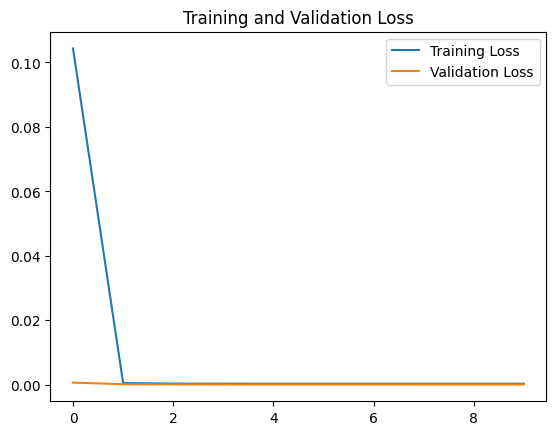

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

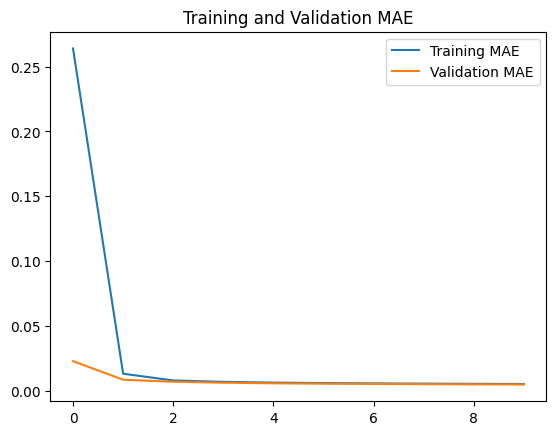

In [11]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

In [12]:
# Evaluate the model using the Data generator
test_gen = data_generator(X_test, y_test, batch_size)

# Calculate the number of steps
test_steps = np.ceil(X_test.shape[0] / batch_size)

# Evaluate the model using the generator
test_loss, test_mae = model.evaluate(test_gen, steps=test_steps)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

22/22 [==============================] - 7s 293ms/step - loss: 7.0880e-05 - mae: 0.0049
Test Loss: 7.087957055773586e-05, Test MAE: 0.004853839520365


In [13]:
# making predictions
prediction = model.predict(X_pred)
prediction.shape

1/1 [==============================] - 2s 2s/step


(2, 3118, 2227)

In [45]:
# Calculate pearson correlation coefficient
r = np.corrcoef(prediction[0], y_pred[0])

# Replace NaN values with 0
r[np.isnan(r)] = 0

# # Create a boolean mask where True represents NaN
# nan_mask = np.isnan(r)

# print("Boolean mask for NaN values:")
# print(nan_mask)

# # Find indices where NaN values are located
# nan_indices = np.where(nan_mask)
# print("Indices of NaN values:")
# print(nan_indices)

# # Count the number of NaN values
# num_nans = np.sum(nan_mask)
# print("Number of NaN values:")
# print(num_nans)

# # Check if there are any NaN values in the correlation matrix
# if np.isnan(r).any():
#     print("Correlation matrix contains NaN values.")
# else:
#     print("No NaN values in the correlation matrix.")

# Flatten the matrix
flat_corr = r.flatten()

# Filter out diagonal elements (which are all 1s)
non_diagonal_elements = [flat_corr[i] for i in range(len(flat_corr)) if i % (r.shape[0] + 1) != 0]

# Calculate the average of non-diagonal elements
average_corr = np.mean(non_diagonal_elements)

print(f"Average Correlation: {average_corr}")

Average Correlation: 0.2640997789747075


# Auxiliary code

In [10]:
# Assuming X_train is your numpy array
num_elements = np.size(X_train)
element_size_bytes = X_train.itemsize
total_size_bytes = num_elements * element_size_bytes
total_size_gb = total_size_bytes / (1024**3)  # Convert from bytes to gigabytes

print(f"Size of X_train in gigabytes: {total_size_gb} GB")

Size of X_train in gigabytes: 14.434131190180779 GB


In [15]:
# Clear accumulated VRAM
cuda.devices.reset()

In [8]:
# Test code
for layer in model.layers:
    print(layer.compute_dtype)

float32
float32
float32
float32
float32
float32
float32
